In [4]:
import pandas as pd
import lightgbm
import numpy as np

from src_clean.dataloader import DataLoader
from src_clean.preprocessor.prepro_new import PreprocessorTwo
from src_clean.ranker.ranker import Ranker
from src_clean.score.ndcg import calculate_ndcg

In [3]:
train_df = pd.read_parquet(f'train_df_basic_statistic_position.parquet')
test_df = pd.read_parquet(f'test_df_basic_statistic_position.parquet')

In [4]:
train_df = PreprocessorTwo.drop_cols(train_df, exclude_cols_to_drop=['srch_id', 'prop_id'])
test_df = PreprocessorTwo.drop_cols(test_df)

In [18]:
X_train, X_valid, y_train, y_valid = DataLoader.split_df_into_train_and_val_batches(train_df, validation_size=0.15)
group_train = [group.shape[0] for group in X_train]
group_val = [group.shape[0] for group in X_valid]

# Final Model

In [19]:
train_data = lightgbm.Dataset(np.vstack(X_train), label=np.hstack(y_train), group=group_train)
valid_data = lightgbm.Dataset(np.vstack(X_valid), label=np.hstack(y_valid), reference=train_data, group=group_val)

In [20]:
params = {
          'metric':'ndcg',
          'objective':'lambdarank',
          'num_iterations': 1500,
          'learning_rate': 0.04,
          'num_leaves': 4095,
          'max_depth': 42,
          'min_child_weight': 1678.407356592231,
          'subsample': 1.0,
          'colsample_bytree': 0.6154980275926369,
          'n_estimators': 9999999,
          'is_unbalance': True,
}

In [21]:
model.best_score['valid']['ndcg@5']

0.42554615035525584

In [ ]:
model = lightgbm.train(
    params=params,
    train_set=train_data,
    valid_sets=[valid_data],
    early_stopping_rounds=100,
    valid_names=['valid'],
)

In [17]:
pred = model.predict(test_df.to_numpy())
ranker = Ranker()
ranking_file_path = ranker.make_ranking_from_prediction(
    pred, model_name="LightGBM"
)
print(f"NDCG@5: {calculate_ndcg(ranking_file_path)}")
print(f"File path: {ranking_file_path}")

NDCG@5: 0.42196867221401524
File path: /Users/robinbux/Desktop/VU/Period5/DataMining/DMT_2022/Assignment_2/rankings/LightGBM/ranking_26_05_2022-32_16.csv


# Different prepro test

In [7]:
params = {
    'metric':'ndcg',
    'objective':'lambdarank',
    'num_iterations': 1500,
    'learning_rate': 0.04,
    'num_leaves': 4095,
    'max_depth': 42,
    'min_child_weight': 1678.407356592231,
    'subsample': 1.0,
    'colsample_bytree': 0.6154980275926369,
    'n_estimators': 9999999,
    'is_unbalance': True,
}

ranker = Ranker()

train_df_vanilla =f'train_df_vanilla.parquet'
test_df_vanilla =f'test_df_vanilla.parquet'

train_df_basic = f'train_df_basic.parquet'
test_df_basic = f'test_df_basic.parquet'

train_df_basic_statistic = f'train_df_basic_statistic.parquet'
test_df_basic_statistic = f'test_df_basic_statistic.parquet'

train_df_basic_statistic_position = f'train_df_basic_statistic_position.parquet'
test_df_basic_statistic_position = f'test_df_basic_statistic_position.parquet'

train_df_basic_statistic_position_normalized = f'train_df_basic_statistic_position_normalized.parquet'
test_df_basic_statistic_position_normalized = f'test_df_basic_statistic_position_normalized.parquet'

eval_df = pd.DataFrame(columns=['model', 'score_valid', 'score_test', 'best_iteration'])

In [6]:
model_row = {'model':'Test', 'score_valid':0.42, 'score_test':0.41, 'best_iteration':97}
eval_df = eval_df.append(model_row, ignore_index=True)


In [28]:
print(eval_df.to_latex(index=False))

\begin{tabular}{llll}
\toprule
                              model & score\_valid & score\_test & best\_iteration \\
\midrule
                            Vanilla &    0.382681 &   0.383641 &            334 \\
                              Basic &    0.391901 &    0.39379 &            425 \\
                    Basic+Statistic &    0.418356 &    0.41406 &            611 \\
           Basic+Statistic+Position &    0.426173 &   0.420684 &            698 \\
Basic+Statistic+Position+Normalized &    0.428746 &   0.422266 &            924 \\
\bottomrule
\end{tabular}



In [8]:
eval_models = {
    #'Vanilla': (train_df_vanilla, test_df_vanilla),
    #'Basic': (train_df_basic, test_df_basic),
    #'Basic+Statistic': (train_df_basic_statistic, test_df_basic_statistic),
    #'Basic+Statistic+Position': (train_df_basic_statistic_position, test_df_basic_statistic_position),
    'Basic+Statistic+Position+Normalized': (train_df_basic_statistic_position_normalized, test_df_basic_statistic_position_normalized)
}

for model_name, (train_df_path, test_df_path) in eval_models.items():
    print('*******************')
    print('*******************')
    print(f'Current model: {model_name}')
    print('*******************')
    print('*******************')

    train_df, test_df = pd.read_parquet(train_df_path), pd.read_parquet(test_df_path)
    train_df = PreprocessorTwo.drop_cols(train_df, exclude_cols_to_drop=['srch_id', 'prop_id'])
    test_df = PreprocessorTwo.drop_cols(test_df)
    set(train_df.columns) - set(test_df.columns)
    if 'position' in train_df.columns and not 'position' in test_df.columns:
        train_df.drop('position', axis=1, inplace=True)
    X_train, X_valid, y_train, y_valid = DataLoader.split_df_into_train_and_val_batches(train_df, validation_size=0.15)
    group_train = [group.shape[0] for group in X_train]
    group_val = [group.shape[0] for group in X_valid]
    train_data = lightgbm.Dataset(np.vstack(X_train), label=np.hstack(y_train), group=group_train)
    valid_data = lightgbm.Dataset(np.vstack(X_valid), label=np.hstack(y_valid), reference=train_data, group=group_val)

    model = lightgbm.train(
        params=params,
        train_set=train_data,
        valid_sets=[valid_data],
        early_stopping_rounds=100,
        valid_names=['valid'],
    )

    pred = model.predict(test_df.to_numpy())
    ranking_file_path = ranker.make_ranking_from_prediction(
        pred, model_name="LightGBM"
    )
    test_score = calculate_ndcg(ranking_file_path)
    print('------------')
    print(f'Model name: {model_name}')
    print(f'Best score valid: {model.best_score["valid"]["ndcg@5"]}')
    print(f"NDCG@5: {test_score}")
    print(f"File path: {ranking_file_path}")

    model_row = {'model':model_name, 'score_valid':model.best_score['valid']['ndcg@5'], 'score_test':test_score, 'best_iteration':model.best_iteration}
    eval_df = eval_df.append(model_row, ignore_index=True)

*******************
*******************
Current model: Basic+Statistic+Position+Normalized
*******************
*******************
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.818148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42530
[LightGBM] [Info] Number of data points in the train set: 4215881, number of used features: 259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid's ndcg@1: 0.147217	valid's ndcg@2: 0.214144	valid's ndcg@3: 0.258035	valid's ndcg@4: 0.291031	valid's ndcg@5: 0.316402
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid's ndcg@1: 0.17193	valid's ndcg@2: 0.243853	valid's ndcg@3: 0.290052	valid's ndcg@4: 0.322202	valid's ndcg@5: 0.347402
[LightGBM] [Warning] No further splits w

In [9]:
from joblib import dump, load
dump(model, 'final_model.joblib')

['final_model.joblib']

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, fig_size = (80, 80)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num], color='blue')
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [51]:
import plotly.express as px
df = pd.DataFrame({'Value':model.feature_importance(),'Feature':train_copy.columns}).sort_values(by="Value",ascending=False)[0:20][::-1]
fig = px.bar(df, x="Value", y="Feature")
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.show(renderer='browser')

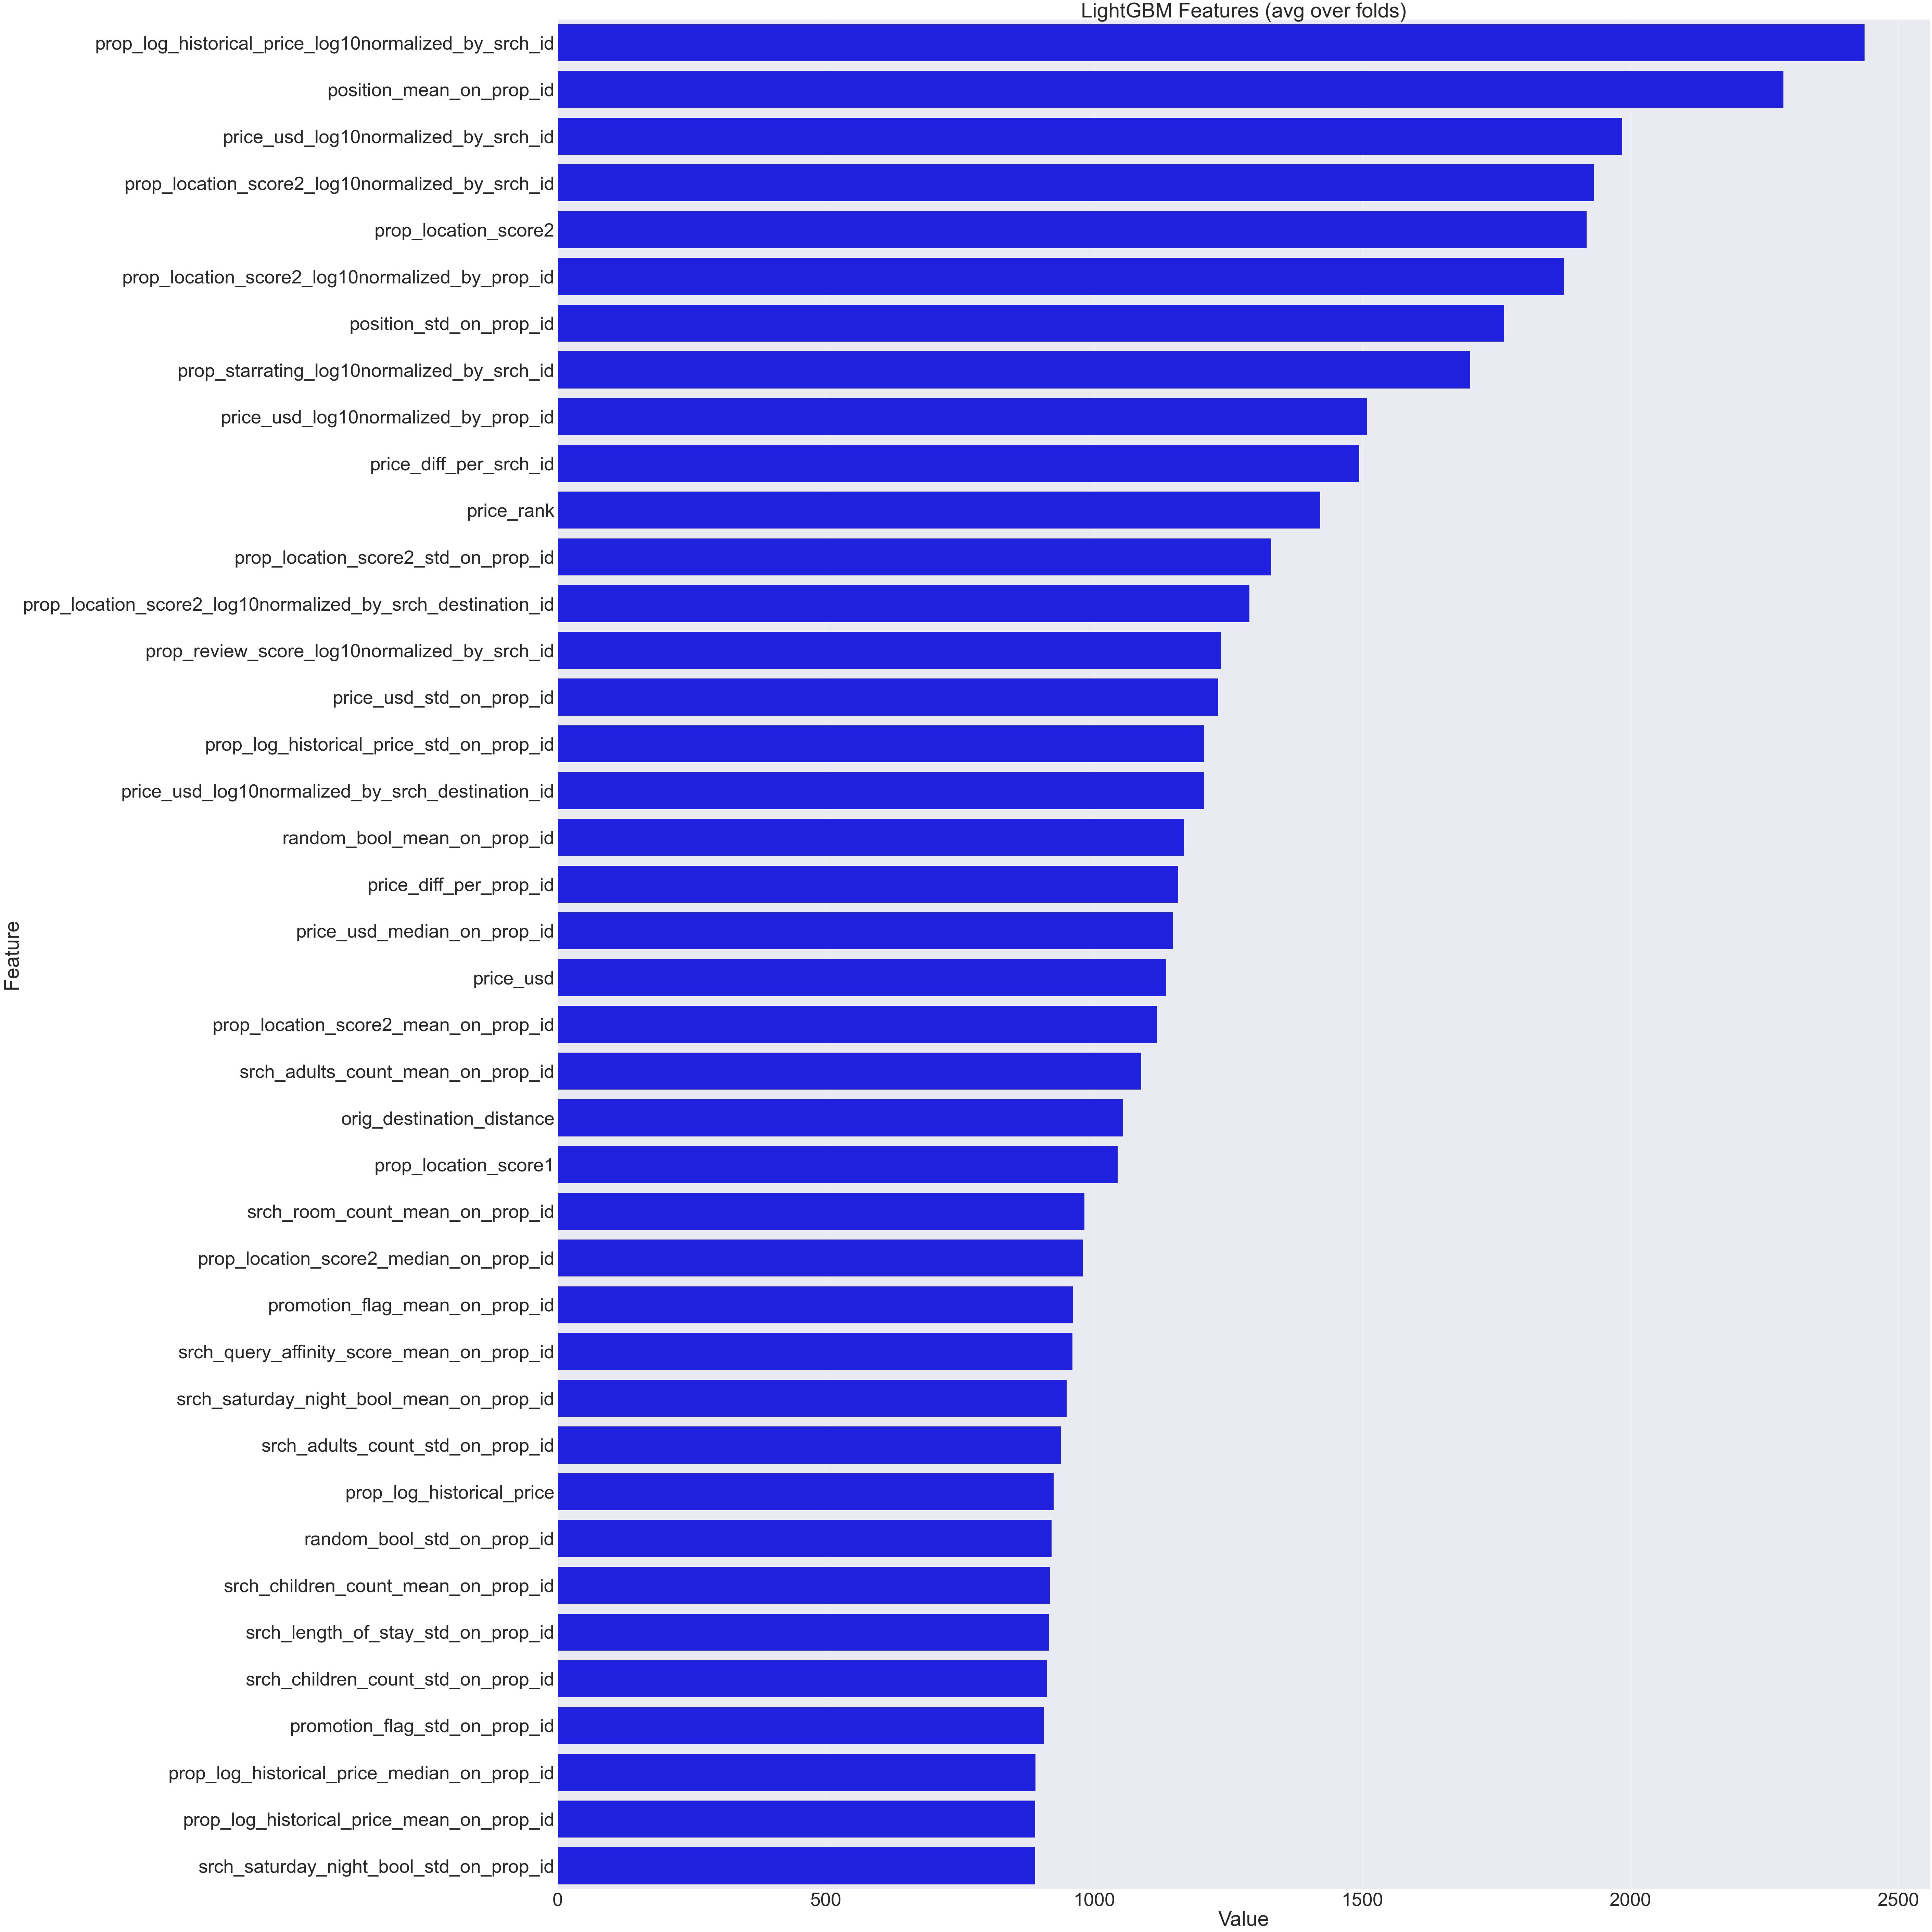

In [32]:
plotImp(model, train_copy, num=40)

In [11]:
train_copy = train_df.copy()

In [40]:
pd.DataFrame({'Value':model.feature_importance(),'Feature':train_copy.columns}).sort_values(by="Value",ascending=False)

ValueError: All arrays must be of the same length

In [18]:
train_copy_cols = train_copy.columns

In [17]:
train_copy.drop(['srch_id', 'prop_id'], axis=1, inplace=True)

In [20]:
train_copy.drop('relevance', axis=1, inplace=True)

In [19]:
len(train_copy_cols)

267

In [36]:
sorted(model.feature_importance())

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 10,
 10,
 12,
 12,
 14,
 15,
 15,
 15,
 19,
 20,
 21,
 22,
 22,
 22,
 22,
 26,
 27,
 27,
 27,
 29,
 34,
 35,
 35,
 39,
 39,
 41,
 44,
 46,
 46,
 47,
 49,
 51,
 52,
 61,
 62,
 62,
 67,
 72,
 73,
 81,
 82,
 94,
 94,
 103,
 104,
 107,
 107,
 111,
 122,
 123,
 123,
 124,
 128,
 129,
 129,
 134,
 139,
 140,
 140,
 146,
 160,
 160,
 173,
 175,
 175,
 183,
 185,
 188,
 193,
 194,
 196,
 198,
 204,
 212,
 217,
 221,
 244,
 247,
 250,
 252,
 252,
 255,
 257,
 258,
 259,
 268,
 270,
 270,
 271,
 271,
 272,
 276,
 278,
 284,
 285,
 291,
 291,
 299,
 302,
 303,
 305,
 308,
 310,
 316,
 316,
 316,
 318,
 319,
 323,
 327,
 327,
 331,
 332,
 332,
 335,
 335,
 343,
 344,
 347,
 349,
 352,
 356,
 357,
 360,
 360,
 366,
 367,
 368,
 370,
 374,
 381,
 381,
 388,
 389,
 392,
 393,
 394,
 395,
 396,
 408,
 423,
 426,
 44

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

Index(['srch_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_id',
       'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price',
       ...
       'price_diff_per_prop_id_log10normalized_by_srch_destination_id',
       'price_diff_per_srch_id_log10normalized_by_srch_id',
       'price_diff_per_srch_id_log10normalized_by_prop_id',
       'price_diff_per_srch_id_log10normalized_by_srch_destination_id',
       'visitor_price_diff_log10normalized_by_srch_id',
       'visitor_price_diff_log10normalized_by_prop_id',
       'visitor_price_diff_log10normalized_by_srch_destination_id',
       'visitor_starrating_diff_log10normalized_by_srch_id',
       'visitor_starrating_diff_log10normalized_by_prop_id',
       'visitor_starrating_diff_log10normalized_by_srch_destination_id'],
      dtype='object', length=269)

269

In [48]:
model.feature_importances_

AttributeError: 'Booster' object has no attribute 'feature_importances_'